# PASSNYC: Data Science for Good Challenge
### _Help PASSNYC determine which schools need their services the most_

- PASSNYC is a not-for-profit organization that facilitates a collective impact that is dedicated to broadening educational opportunities for New York City's talented and underserved students. 
- PASSNYC aims to increase the diversity of students taking the Specialized High School Admissions Test (SHSAT)

# Initital Setup
## Import packages

In [1]:
import numpy as np 
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import date
import seaborn as sns
import random 
import warnings
import operator
warnings.filterwarnings("ignore")

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

## Load data

`2016 School Explorer.csv`
 - Including general school information, school evaluations and students scores
 - Shape: (1271, 161)

In [2]:
schl_df = pd.read_csv("2016 School Explorer.csv")

`D5 SHSAT Registrations and Testers.csv`
- District 5 (Central Harlem) SHSAT (Specialized High School Test) data from the NYC Department of Education: Time series enrollment, SHSAT registrations & participation for that community
- Shape: (140, 7)

In [3]:
reg_df = pd.read_csv("D5 SHSAT Registrations and Testers.csv")

## Create a class to facilitate data visualization

In [4]:
class data_chart():
    """ 
    Class to visualize data features
    """
    def __init__(self, df, column_name, data_type):
        """
        Initialize class
            data_type: 'cat' or 'value'
        """
        self.column_name = column_name
        self.column_data = df[column_name]
        if data_type == 'cat':
            self.cat_data()
        elif data_type == 'value':
            self.value_data()
        else:
            raise NotImplementedError
        self.data_type = data_type
        
    def cat_data(self):
        nlst, clst = [], []
        cdict = self.column_data.value_counts().to_dict()
        cdict = sorted(cdict.items(), key=operator.itemgetter(1))
        for tup in cdict:
            nlst.append(tup[0])
            clst.append(tup[1])
        self.nlst = nlst
        self.clst = clst
        
    def value_data(self):
        self.values = self.column_data
        
    def plot(self, cat='bar', **kwargs):
        """
        Visualize data
        """
        if self.data_type == 'cat':
            fig = self.plot_cat(cat=cat, **kwargs)
        elif self.data_type == 'value':
            fig = self.plot_value(**kwargs)
            
        py.iplot(fig, filename=f'plot_of_{self.column_name}')
        
    def plot_cat(self, cat, **kwargs):
        data_bar = {"y": self.nlst, "x": self.clst, "width": 0.9, "opacity": 0.6, "orientation": 'h', "type": 'bar'}
        data_bar['hovertext'] = list(map(lambda i: f'{i/sum(self.clst)*100:.2f}%', self.clst))
        
        data_pie = {'values': self.clst, "labels": self.nlst, "hoverinfo": 'label+percent', 
                    "type": 'pie', "hole": .3}
        
        layout = {"title": self.column_name, "autosize": True,
                  "paper_bgcolor":'rgb(243, 243, 243)', "plot_bgcolor":'rgb(243, 243, 243)'}
    
        if 'data_bar' in kwargs:
            data_bar.update(kwargs['data_bar'])
            
        if 'data_pie' in kwargs:
            data_pie.update(kwargs['data_pie'])   
            
        if 'layout' in kwargs:
            layout.update(kwargs['layout'])      
        if cat == 'bar':
            return {"data": [data_bar], "layout": layout}
        elif cat == 'pie':
            return {"data": [data_pie], "layout": layout}
        else:
            raise NotImplementedError
            
    def plot_value(self, **kwargs):
        data_hist = {"y": self.values, "name": self.column_name, "type": 'histogram'}   
        data_box  = {"y": self.values, "name": 'Mean & SD', 'type': 'box', 'boxmean': 'sd'}
        layout = {"title": f'Data analysis for {self.column_name}', 
                  "paper_bgcolor":'rgb(243, 243, 243)', "plot_bgcolor":'rgb(243, 243, 243)',
                  "showlegend": False, 
                  'yaxis': {'title': self.column_name}, 
                  'xaxis1': {'title': 'count'}, 
                  'xaxis2': {'title': f'Mean = {np.mean(self.values):.4f}'}}
        
        if 'data_hist' in kwargs:
            data_hist.update(kwargs['data_hist'])
        
        if 'data_box' in kwargs:
            data_box.update(kwargs['data_box'])
            
        if 'layout' in kwargs:
            layout.update(kwargs['layout'])
            
        fig = tls.make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=('Histogram', 'Boxplot'))
        fig.append_trace(data_hist, 1, 1)
        fig.append_trace(data_box, 1, 2)
      
        fig['layout'].update(layout)
        
        return fig

# EDA of '_2016 School Explorer.csv_'
<h2>School City</h2>

In [5]:
school_city = data_chart(schl_df, 'City', 'cat')
margin = go.Margin(l=250, r=50, b=100, t=100, pad=20)
school_city.plot(**{'layout':{'margin': margin, 'height':800}})

In [6]:
school_city.plot('pie')

According to the above charts, Most of the Schools are from Brooklyn(32.3%), followed by Bronx(23.3%), New York(18.2%), Staten Island(4.72%), Jamaica(2.52%)

<h2>Community College or Not</h2>

In [7]:
sch_cmnty = data_chart(schl_df, 'Community School?', 'cat')
sch_cmnty.plot('pie', **{'data_pie': {'hole': 0}})

Out of the given 1272 colleges, only 76 of them are Community colleges.

<h2>High Grade</h2>

In [8]:
high_grd = data_chart(schl_df, 'Grade High', 'cat')
x = list(map(lambda x: f'Grade {x}', high_grd.nlst))
y = high_grd.clst
high_grd.plot(**{'data_bar': {'x': x, 'y': y, 'orientation': 'v', 'width': 0.5},
                 'layout': {'width': 600, 'xaxis': dict(tickangle=-45)}
                })

## School Income Estimate & Economic Need Index 
### School Income Estimate 

In [9]:
def get_dollar_amount(x):
    x = str(x)
    if x == 'nan':
        return np.nan
    else:
        return float(x.strip().replace('$', '').replace(',',''))
    
schl_df['School Income Estimate'] = schl_df['School Income Estimate'].apply(get_dollar_amount)

In [10]:
school_sie = data_chart(schl_df, 'School Income Estimate', 'value')
school_sie.plot()

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]



Most of the colleges have income from 25k to 45k, There are a few colleges with extremely high incomes like 140k and 180k. 

### Economic Need Index


- Economic Need Index = (Percent Temporary Housing) + (Percent
HRA-eligible * 0.5) + (Percent Free Lunch Eligible * 0.5)

In [11]:
sch_eni = data_chart(schl_df, 'Economic Need Index', 'value')
sch_eni.plot()

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]



### School Income Estimate & Economic Need Index correlation

In [12]:
trace0 = go.Scatter(
    x=schl_df[schl_df['Community School?'] == 'No']['Economic Need Index'],
    y=schl_df[schl_df['Community School?'] == 'No']['School Income Estimate'],
    hovertext=schl_df[schl_df['Community School?'] == 'No']['School Name'],
    hoverlabel=dict(bgcolor="rgb(230,160,0)"),
    mode='markers',
    name='Non-Community',
    marker=dict(
        size=2.8,
        line=dict(
            width=2.5,
            color="rgb(230, 160, 0)"
        ),
        
    )
)
trace1 = go.Scatter(
    x=schl_df[schl_df['Community School?'] == 'Yes']['Economic Need Index'],
    y=schl_df[schl_df['Community School?'] == 'Yes']['School Income Estimate'],
    hovertext=schl_df[schl_df['Community School?'] == 'Yes']['School Name'],
    hoverlabel=dict(bgcolor="rgb(120, 0, 255)"),
    mode='markers',
    name='Community',
    marker=dict(
        size=2,
        line=dict(
            width=10,
            color="rgb(120, 0, 255)"
        ),
        
    )
)

data = [trace0, trace1]
layout = go.Layout(
      hovermode = 'closest',
      height=650,
      width=720,
      xaxis=dict(title='Economic Need Index', range=[0, 1], zeroline=False, showline=True),
      yaxis=dict(title='School Income Estimate', autorange=True, zeroline=False, showline=True),
      title=('School economic need'))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

<h2>Framework for Great Schools</h2>
The School Quality Reports share ratings and information on how schools are
performing on the six Framework elements.
- **Rigorous Instruction**: Instruction
- **Collaborative Teachers**: Teachers
- **Supportive Environment**: Environment
- **Effective School Leadership**: Leadership
- **Strong Family-Community Ties**: Ties
- **Trust**: Trust

In [13]:
def rating_data(column_name):
    column_name += ' Rating'
    dct = schl_df[column_name].value_counts().to_dict()
    return go.Bar(
                y = list(dct.values()),
                x = list(dct.keys()),
                width = 0.9,
                opacity = 0.6, 
                orientation = 'v', 
                name = column_name,
                marker = dict(color='rgb(158,202,225)', line=dict(color='rgb(8,48,107)', width=1.5))
            )

def ratio_data(column_name):
    column_name += ' %'
    return go.Histogram(x = schl_df[column_name], name = column_name)

In [14]:
cols = ['Rigorous Instruction', 'Collaborative Teachers', 'Supportive Environment',
        'Effective School Leadership', 'Strong Family-Community Ties', 'Trust']

In [15]:
st = []
for c in cols:
    st.append(f'{c} Rating')
    st.append(f'{c} %')
st = tuple(st)

fig = tls.make_subplots(rows=6, cols=2, subplot_titles=st)

i = 1
for c in cols:
    fig.append_trace(rating_data(c), i, 1)
    fig.append_trace(ratio_data(c), i, 2)
    i += 1


fig['layout'].update(height=2400,title='School Quality Report Charts', showlegend=False, 
                     paper_bgcolor='rgb(243, 243, 243)',plot_bgcolor='rgb(243, 243, 243)')
py.iplot(fig, filename='simple-subplot')

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]  
[ (2,1) x3,y3 ]    [ (2,2) x4,y4 ]  
[ (3,1) x5,y5 ]    [ (3,2) x6,y6 ]  
[ (4,1) x7,y7 ]    [ (4,2) x8,y8 ]  
[ (5,1) x9,y9 ]    [ (5,2) x10,y10 ]
[ (6,1) x11,y11 ]  [ (6,2) x12,y12 ]



In [16]:
dimensions_lst = []
for i in cols:
    name = i + ' %'
    dimensions_lst.append(dict(label=name, values=schl_df[name]))


trace=go.Splom(dimensions=dimensions_lst, marker=dict(size=5, opacity=0.4, color='blue'))
                           
axis = dict(showline=True,
            zeroline=False,
            gridcolor='#fff',
            ticklen=4.,
            tickangle=-30
        )
trace['showupperhalf']=False    
#trace['diagonal'].update(visible=False)

layout = go.Layout(
    title='Correlation between school performances',
    dragmode='select',
    width=900,
    height=900,
    autosize=False,
    hovermode='closest',
    plot_bgcolor='rgba(240,240,240, 0.95)',
    xaxis1=dict(axis, range=[60, 100], title='Instruction'),
    xaxis2=dict(axis, range=[50, 100], title='Teachers'),
    xaxis3=dict(axis, range=[60, 100], title='Environment'),
    xaxis4=dict(axis, range=[30, 100], title='Leadership'),
    xaxis5=dict(axis, range=[60, 100], title='Ties'),
    xaxis6=dict(axis, range=[60, 100], title='Trust'),
    yaxis1=dict(axis, range=[60, 100], title='Instruction'),
    yaxis2=dict(axis, range=[50, 100], title='Teachers'),
    yaxis3=dict(axis, range=[60, 100], title='Environment'),
    yaxis4=dict(axis, range=[30, 100], title='Leadership'),
    yaxis5=dict(axis, range=[60, 100], title='Ties'),
    yaxis6=dict(axis, range=[60, 100], title='Trust'),
)

fig1 = dict(data=[trace], layout=layout)
py.iplot(fig1, filename='splom')    

<h2>Student Achievement Rating</h2>

In [17]:
sch_sar = data_chart(schl_df, 'Student Achievement Rating', 'cat')
sch_sar.plot('pie')

<h2>Average Math and ELA Proficiency</h2>
Understanding Proficiency provides resources that guide educators in analyzing student work on performance tasks in order to develop a deeper understanding of the Maths/English Language Arts (ELA)/Literacy Common Core State Standards

In [18]:
ave_math = data_chart(schl_df, 'Average Math Proficiency', 'value')
ave_math.plot()

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]



In [19]:
ave_ela = data_chart(schl_df, 'Average ELA Proficiency', 'value')
ave_ela.plot()

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]



<h2>Students Chronically Absent</h2>

In [20]:
def convert_percent(x):
    x = str(x)
    if x == 'nan':
        return np.nan
    else:
        return float(x.strip().replace('%', ''))

schl_df['Percent of Students Chronically Absent']  = schl_df['Percent of Students Chronically Absent'].apply(convert_percent)

In [21]:
ave_ela = data_chart(schl_df, 'Percent of Students Chronically Absent', 'value')
ave_ela.plot(**{'layout': {'title': f'Data analysis {ave_ela.column_name} (%)', 
                           'yaxis':{'title': f'{ave_ela.column_name} (%)'},
                           'xaxis2': {'title': f'Mean = {np.mean(ave_ela.values):.2f} (%)'}
                          }
               })

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]



## Correlation between ELA proficiency, math proficiency and student absent percent

In [22]:
trace=go.Splom(dimensions=[dict(label='Percent of Students Chronically Absent',
                                values=schl_df['Percent of Students Chronically Absent']),
                           dict(label='Average ELA Proficiency',
                                values=schl_df['Average ELA Proficiency']),
                           dict(label='Average Math Proficiency',
                                values=schl_df['Average Math Proficiency'])],
#                            text=text,
                            marker=dict(size=5, opacity=0.4, color='blue')
               )
                           
axis = dict(showline=True,
          zeroline=False,
          gridcolor='#fff',
          ticklen=4)
                           
layout = go.Layout(
    title='Correlation between ELA proficiency, math proficiency and student absent percent',
    dragmode='select',
    width=900,
    height=900,
    autosize=False,
    hovermode='closest',
    plot_bgcolor='rgba(240,240,240, 0.95)',
    xaxis1=dict(axis),
    xaxis2=dict(axis),
    xaxis3=dict(axis),
    yaxis1=dict(axis),
    yaxis2=dict(axis),
    yaxis3=dict(axis),
)

fig1 = dict(data=[trace], layout=layout)
py.iplot(fig1, filename='splom')                           

<h2>Scores for ELA and Maths from Grade 3 to Grade 8</h2>

In [23]:
schl_df.rename(index=str, 
               columns={"Grade 3 Math - All Students tested": "Grade 3 Math - All Students Tested"},
               inplace=True)

In [24]:
# Create a trace
colors = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, 12)]
race = ['All Students','American Indian or Alaska Native','Black or African American',
          'Hispanic or Latino','Asian or Pacific Islander','White',
          'Multiracial','Limited English Proficient','Economically Disadvantaged']
subject = ['ELA', 'Math']

def show_scores(grade):
    all_trace = {}
    for s in subject:
        schl_cnt = []
        stdnt_cnt = []
        stdnt_pccnt = []
        tot_stdnt = schl_df[f'Grade {grade} {s} - All Students Tested'].sum()
        for r in race:
            schl_cnt.append(len(schl_df[schl_df[f'Grade 3 {s} 4s - {r}'] > 0]))
            stdnt_cnt.append(schl_df[f'Grade 3 {s} 4s - {r}'].sum())
            stdnt_pccnt.append(schl_df[f'Grade 3 {s} 4s - {r}'].sum()/tot_stdnt)

        trace = go.Scatter(
                        x=race,
                        y=schl_cnt,
                        mode='markers',
                        name = f'Grade {grade} {s}',
                        hovertext=list(map(lambda i: f'{stdnt_cnt[i]} students in {schl_cnt[i]} schools<br>{stdnt_pccnt[i]*100:.2f}% out of all student tested', 
                                        range(len(race)))),
                        marker=dict(size=[x*300 + 10 for x in stdnt_pccnt],
                                   color=colors[:len(race)],)
                            )
        all_trace[s] = trace

    fig = tls.make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=(f'ELA', f'Math'));
    fig.append_trace(all_trace['ELA'], 1, 1);
    fig.append_trace(all_trace['Math'], 1, 2);

    fig['layout'].update(height=500, title=f'Count of Students scoring 4s in Grade {grade}', 
                         showlegend=False,paper_bgcolor='rgb(243, 243, 243)',
                         yaxis1 = dict(title='Number of schools'),
                         yaxis2 = dict(title='Number of schools'), 
                         xaxis1 = dict(tickangle=-50), 
                         xaxis2 = dict(tickangle=-50), 
                         plot_bgcolor='rgb(243, 243, 243)',
                         margin = go.Margin(l=150, r=90, b=190, t=100, pad=20));

    py.iplot(fig, filename='Proficiency-subplot')

In [25]:
show_scores(8)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y1 ]



# EDA of '_D5 SHSAT Registrations and Testers.csv_'

In [26]:
#reg_df[['School name', 'DBN']].groupby(['DBN', 'School name']).count()

In [27]:
#reg_df.head()

<h2>Number of students who registered/took for the SHSAT</h2>


In [28]:
reg_shsat_per_schl = reg_df[['School name', 'Enrollment on 10/31', 'Number of students who registered for the SHSAT', 
                             'Number of students who took the SHSAT']].groupby('School name').sum().reset_index()
reg_shsat_per_schl.rename(index=str, columns={'Enrollment on 10/31': 'enrolled',
                                              'Number of students who registered for the SHSAT': 'registered',
                                              'Number of students who took the SHSAT': 'took'},
                         inplace=True)
reg_shsat_per_schl['not_took'] = reg_shsat_per_schl['registered'] - reg_shsat_per_schl['took']
reg_shsat_per_schl.sort_values(by='registered', inplace=True)

In [29]:
wd = 0.6
trace0 = go.Bar(
    y=reg_shsat_per_schl['School name'],
    x=reg_shsat_per_schl['took'],
    text=list(map(lambda x: f'{x} Students<br>Took SHSAT', reg_shsat_per_schl['took'])),
    hoverinfo = 'text',    
    orientation = 'h',
    width = wd, 
)

trace1 = go.Bar(
    y=reg_shsat_per_schl['School name'],
    x=reg_shsat_per_schl['not_took'],
    text=list(map(lambda x: f'{x} Students<br>Registered SHSAT', reg_shsat_per_schl['registered'])),
    hoverinfo = 'text',
    orientation = 'h',
    width = wd, 
)

data = [trace0, trace1]
layout = go.Layout(
    barmode='stack',
    showlegend = False,
    margin=go.Margin(
        l=450,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    height = 900,
    
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='marker-h-bar')

In [30]:
reg_shsat_per_year = reg_df[['Year of SHST', 'Enrollment on 10/31', 'Number of students who registered for the SHSAT', 
                             'Number of students who took the SHSAT']].groupby('Year of SHST').sum().reset_index()
reg_shsat_per_year.rename(index=str, columns={'Year of SHST': 'year',
                                              'Enrollment on 10/31': 'enrolled',
                                              'Number of students who registered for the SHSAT': 'registered',
                                              'Number of students who took the SHSAT': 'took'},
                         inplace=True)
reg_shsat_per_year['not_took'] = reg_shsat_per_year['registered'] - reg_shsat_per_year['took']
reg_shsat_per_year['year'] = reg_shsat_per_year['year'].apply(lambda x: f'Year {x}')

In [31]:
wd = 0.32
trace0 = go.Bar(
    y=reg_shsat_per_year['year'],
    x=reg_shsat_per_year['took'],
    text=list(map(lambda x: f'{x} Students Took SHSAT', reg_shsat_per_year['took'])),
    hoverinfo = 'text',    
    orientation = 'h',
    width = wd, 
    offset=-wd,
    marker = dict(color = "rgb(250, 30, 0)"),
)

trace1 = go.Bar(
    y=reg_shsat_per_year['year'],
    x=reg_shsat_per_year['not_took'],
    text=list(map(lambda x: f'{x} Students Registered SHSAT', reg_shsat_per_year['registered'])),
    hoverinfo = 'text',
    orientation = 'h',
    width = wd, 
    offset=-wd,
    marker = dict(color = "rgb(250, 180, 0)"),
)

trace2 = go.Bar(
    y=reg_shsat_per_year['year'],
    x=reg_shsat_per_year['enrolled'],
    text=list(map(lambda x: f'{x} Students Enrolled', reg_shsat_per_year['enrolled'])),
    hoverinfo = 'text',
    orientation = 'h',
    width = wd, 
    base=0,
    offset= 0,
    marker = dict(color = "rgb(0,120,255)"),
)
data = [trace0, trace1, trace2]
layout = go.Layout(
    barmode='stack',
    showlegend = False,
    height = 500,
    xaxis = {'title': 'Number of students'},
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='marker-h-bar')

# Our goal: identify schools qualified for helping aid from PSSNYC
## Merge table, data cleaning, feature engineering

In [32]:
# Let's reload the data
schl_df = pd.read_csv("2016 School Explorer.csv")
reg_df = pd.read_csv("D5 SHSAT Registrations and Testers.csv")

# Add percentage features for SHSAT and enrollment
reg_df['taken_pct'] = reg_df['Number of students who took the SHSAT']/reg_df['Number of students who registered for the SHSAT']
reg_df['reg_enrl_pct'] = reg_df["Number of students who registered for the SHSAT"]/reg_df["Enrollment on 10/31"] 
reg_df['taken_enrl_pct'] = reg_df['taken_pct']*reg_df['reg_enrl_pct']

# Merge data into school data
filtered_reg_df = reg_df.drop_duplicates(subset=['School name','Year of SHST'])
filtered_reg_df = filtered_reg_df[filtered_reg_df['Year of SHST'] == 2016] 
filtered_reg_df = filtered_reg_df[filtered_reg_df['Grade level'] == 8]
School_Reg_merged = pd.merge(filtered_reg_df, schl_df, how='left', left_on='DBN', right_on='Location Code')
School_Reg_merged = School_Reg_merged[np.isfinite(School_Reg_merged['Economic Need Index'])]

# Encoding community school
School_Reg_merged['Community School?'] = School_Reg_merged['Community School?'].map(lambda s: 1 if s == 'Yes' else 0)

# Convert percent values to float
pct_features = ["Student Attendance Rate", "Percent of Students Chronically Absent",
            "Rigorous Instruction %", "Collaborative Teachers %",
            "Supportive Environment %", "Effective School Leadership %",
            "Strong Family-Community Ties %", "Trust %",
            "Percent Black", "Percent White", "Percent Asian", "Percent Hispanic",
            "Percent Black / Hispanic", "Percent ELL"]

for i, cn in enumerate(School_Reg_merged[pct_features]):
     School_Reg_merged[str(cn)]=School_Reg_merged[str(cn)].replace({'%':'', ',':''},regex=True).astype(float)

# Label encoding all the Rating features
mapping_dict = {"Not Meeting Target":0, "Approaching Target":1, "Meeting Target":2, "Exceeding Target" : 3}
def label_encoding(df, column_name):
    df[column_name] = df[column_name].map(mapping_dict)
    df[column_name].fillna(-1, inplace=True)
    df[column_name] = df[column_name].astype(int)

rating_cols = ['Rigorous Instruction Rating', 'Collaborative Teachers Rating', 
               'Supportive Environment Rating', 'Effective School Leadership Rating',
               'Strong Family-Community Ties Rating', 'Trust Rating','Student Achievement Rating']    

for c in rating_cols:
    label_encoding(School_Reg_merged, c)

# Drop unimportant features
School_Reg_merged.drop(['School Income Estimate','Adjusted Grade','New?','Other Location Code in LCGMS'], axis =1, inplace = True)

## Setup features and target

In [33]:
# visualize data and try to set up a criteria.
# Schools whose SHSAT participation below this crieria might need aid from PSSNYC
trace = go.Scatter(
                x=School_Reg_merged['Economic Need Index'],
                y=School_Reg_merged['taken_enrl_pct'],
                mode='markers',
                #name = f'Grade {grade} {s}',
                text = School_Reg_merged['School name'],
                hoverinfo = 'text',
                marker=dict(size=12.5,
                           color='orange')
                            )
layout = go.Layout(
    showlegend = False,
    margin=go.Margin(
        l=90,
        r=50,
        b=50,
        t=50,
        pad=20
    ),
    height=600,
    width=630,
    paper_bgcolor='rgb(243, 243, 243)', 
    plot_bgcolor='rgb(243, 243, 243)',
    yaxis = dict(title='Percent participation in 2016', autorange=True, showline=False),
    xaxis = dict(title='Economic Need Index', autorange=True, showline=False)
)
fig = {'data': [trace], 'layout': layout}
py.iplot(fig, filename='check_target')

In [34]:
# Get final features and target
features = School_Reg_merged.iloc[:,22:167] # all main table features
target = School_Reg_merged['taken_enrl_pct'].map(lambda s: 1 if s >= 0.3 else 0)

## Useful function to handle features

In [35]:
def plot_fi(model, ftrs):
    """
    Function to plot feature importance
    """
    x, y = (list(x) for x in zip(*sorted(zip(model.feature_importances_, ftrs), reverse = False)))
    trace = go.Bar(
        x=x ,
        y=y,
        marker=dict(
            color=x,
            colorscale = 'RdBu',
            reversescale = True
        ),
        name=str(model_clf.__class__).split("'")[1].split('.')[-1],
        orientation='h',
    )

    layout = dict(
        title='Feature importances plot',
        width = 900, height = 3000,
        yaxis=dict(
            showgrid=False,
            showline=False,
            showticklabels=True,
    #         domain=[0, 0.85],
        ),
        margin=dict(
        l=300,
    ),
    )

    fig1 = go.Figure(data=[trace], layout=layout)
    py.iplot(fig1)
    
def select_features(model, ftrs, criteria):
    """
    Function to select features based on feature importance
    """
    ftrs_lst = []
    for name, importance in zip(ftrs, model.feature_importances_):
        if importance > 0.02 :
            ftrs_lst.append(name)
    return ftrs_lst

## RandomForest Model to select features

In [36]:
from sklearn.ensemble import RandomForestClassifier

model_clf = RandomForestClassifier(n_estimators = 1000 , criterion = 'entropy', random_state = 0)
model_clf.fit(features, target)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [37]:
plot_fi(model_clf, features)

In [38]:
# select features
selected_features = select_features(model_clf, features, 0.02)
train = School_Reg_merged[selected_features]

## Train model to look for schools to help using PSSNYC

In [39]:
# Train models
X = train.values 
y = target.values

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Train multiple ensembles
test_all = []
predict_all = []
rf_lst = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = i)

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    classifier = RandomForestClassifier(n_estimators = 1000 , criterion = 'entropy', random_state = i)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    score = classifier.score(X_test, y_test)
    print(f'Batch {i+1}, Score = {score}')
      
    test_all.extend(y_test)
    predict_all.extend(y_pred)
    
    if score > 0.5:
        rf_lst.append(classifier)

Batch 1, Score = 0.8333333333333334
Batch 2, Score = 1.0
Batch 3, Score = 1.0
Batch 4, Score = 0.8333333333333334
Batch 5, Score = 0.8333333333333334
Batch 6, Score = 0.8333333333333334
Batch 7, Score = 1.0
Batch 8, Score = 0.8333333333333334
Batch 9, Score = 0.8333333333333334
Batch 10, Score = 1.0


In [40]:
# Combine multiple models into a big one
def combine_rfs(rf_lst):
    rf_out = rf_lst[0]
    for rf in rf_lst[1:]:
        rf_out.estimators_ += rf.estimators_
    rf_out.n_estimators = len(rf_out.estimators_)
    return rf_out

final_rf = combine_rfs(rf_lst)

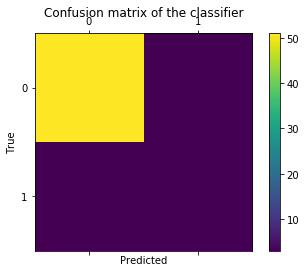

In [41]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_all, predict_all)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Apply model to other schools
### Feature engineering

In [42]:
# Load data
school_reg = pd.read_csv("2016 School Explorer.csv")

# Feature engineering
school_reg = school_reg[np.isfinite(school_reg['Economic Need Index'])]

# Encoding community school
school_reg['Community School?'] = school_reg['Community School?'].map(lambda s: 1 if s == 'Yes' else 0)

# Convert percent values to float
def convert_percent(x):
    x = str(x)
    if x == 'nan':
        return np.nan
    else:
        return float(x.strip().replace('%', '').replace(',', ''))

for i, cn in enumerate(school_reg[pct_features]):
     school_reg[str(cn)]=school_reg[str(cn)].apply(convert_percent)

# Label encoding all the Rating features  
for c in rating_cols:
    label_encoding(school_reg, c)

# Focus on Grade 08
school_reg = school_reg[school_reg['Grade High'] == '08']

# Final cleanup NAN data
school_reg['Average ELA Proficiency'].fillna(0, inplace=True)
school_reg['Average Math Proficiency'].fillna(0, inplace=True)
school_reg.drop(['School Income Estimate','Adjusted Grade','New?','Other Location Code in LCGMS'], axis =1, inplace = True)

school_reg.reset_index(inplace=True)

### Predict using our model

In [43]:
X = school_reg[selected_features]
y_pred = final_rf.predict(X)

final_pred = school_reg.copy()
final_pred['Need'] = 1 - y_pred

### Total need based on our prediction

In [44]:
t = final_pred['Need'].value_counts()

labels = ['No Need', 'Need']
values = list(t.values)

layout = go.Layout(title='Overall Stats of schools in need', width=1000, height=500, margin=dict(l=100), xaxis=dict(tickangle=-65))
trace1 = go.Bar(x=labels, y=values,marker=dict(color=['red', 'yellow']))


data = [trace1]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### Geospatial of our prediction

In [45]:
import folium
from folium import plugins
from io import StringIO
import folium 

colors = ['red', 'yellow']
d = (final_pred['Need']).astype('int')

cols = [colors[int(i/1)] for i in d]

m = folium.Map([final_pred['Latitude'][0], final_pred['Longitude'][0]], zoom_start=10.3,tiles='cartodbdark_matter')

for lat, long, col in zip(final_pred['Latitude'], final_pred['Longitude'], cols):
    #rown = list(rown)
    folium.CircleMarker([lat, long], color=col, fill=True, radius=3).add_to(m)
m

### Using PCA to reduce feature dimensionality and retrain RandomForest model

In [46]:
all_schl = school_reg.iloc[:,13:] 

scaler = StandardScaler()
scaler.fit(features)

features_sc = scaler.transform(features)
all_schl_sc = scaler.transform(all_schl)

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca.fit(features_sc)

features_pca = pca.transform(features_sc)
all_schl_pca = pca.transform(all_schl_sc)

In [48]:
X = features_pca
y = target.values

# Train multiple ensembles
test_all = []
predict_all = []
rf_lst = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = i)

    classifier = RandomForestClassifier(n_estimators = 1000 , criterion = 'entropy', random_state = i)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    score = classifier.score(X_test, y_test)
    print(f'Batch {i+1}, Score = {score}')
      
    test_all.extend(y_test)
    predict_all.extend(y_pred)
    
    if score > 0.5:
        rf_lst.append(classifier)

Batch 1, Score = 0.8
Batch 2, Score = 1.0
Batch 3, Score = 1.0
Batch 4, Score = 1.0
Batch 5, Score = 1.0
Batch 6, Score = 0.8
Batch 7, Score = 0.8
Batch 8, Score = 1.0
Batch 9, Score = 0.8
Batch 10, Score = 0.8


In [49]:
final_rf_pca = combine_rfs(rf_lst)
y_pred = final_rf_pca.predict(all_schl_pca)

final_pred_pca = school_reg.copy()
final_pred_pca['Need'] = 1 - y_pred

t = final_pred_pca['Need'].value_counts()

labels = ['No Need', 'Need']
values = list(t.values)

layout = go.Layout(title='Overall Stats of schools in need', width=1000, height=500, margin=dict(l=100), xaxis=dict(tickangle=-65))
trace1 = go.Bar(x=labels, y=values,marker=dict(color=['red', 'yellow']))


data = [trace1]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)